<h1><center> Assignment 1: EDA United Nations General Debate Corpus  </center></h1>

In [1]:
import os
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
warnings.filterwarnings("ignore")

## Preprocessing

### 1) UN General Debate Corpus

First, we load the *UN General Debate Corpus* (UNGDC) dataset, to which we have added the speeches from 2021. 

In [3]:
sessions = np.arange(25, 77)
data=[]

for session in sessions:
    directory = "./TXT/Session "+str(session)+" - "+str(1945+session)
    for filename in os.listdir(directory):
        f = open(os.path.join(directory, filename))
        if filename[0]==".": #ignore hidden files
            continue
        splt = filename.split("_")
        data.append([session, 1945+session, splt[0], f.read()])

        
df_speech = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])

df_speech.tail()

,Session,Year,ISO-alpha3 Code,Speech
8591,76,2021,NRU,His Excellency Hon. Lionel Rouwen Aingimea M.P...
8592,76,2021,BTN,"Statement by His Excellency Dr Lotay Tshering,..."
8593,76,2021,SRB,"Mr. President,\nMr. Secretary General,\nExcell..."
8594,76,2021,SYR,Statement by\n\nH.E. Fayssal Mekdad\nMinister ...
8595,76,2021,DNK,"The General Debate, 76th United Nations Genera..."


Next, we load the *UNSD – Methodology* data into a dataframe called "df_codes".

In [4]:
df_codes = pd.read_csv("/Users/matejloncaric/Fundamentals of Data Science/UNSD — Methodology.csv", sep=';')
df_codes.head()

,Global Code,Global Name,Region Code,Region Name,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,M49 Code,ISO-alpha2 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS)
0,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Algeria,12,DZ,DZA,NaN,NaN,NaN
1,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Egypt,818,EG,EGY,NaN,NaN,NaN
2,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Libya,434,LY,LBY,NaN,NaN,NaN
3,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Morocco,504,MA,MAR,NaN,NaN,NaN
4,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Sudan,729,SD,SDN,x,NaN,NaN


We create a merged dataframe between df_codes and df_speech, according to the ISO-alpha 3 Code.

Since the Exploratory Data Analysis will be done per region, a new column "Regions" is created. This column dirrectly corresponds to the "Region Name" column from *df_codes*, except that the region "Americas" is separated into "North America" and "Latin America", using the data from the "Sub-region Name" column of the same dataframe.

In [5]:
dataframe = pd.merge(df_speech, df_codes, how='inner', on = 'ISO-alpha3 Code')
dataframe.head()
final_df = dataframe[["Country or Area", "Region Name","Sub-region Name", "ISO-alpha3 Code","Least Developed Countries (LDC)", "Session", "Year", "Speech"]]

subregions = list(final_df["Sub-region Name"].unique())
final_df["Regions"] = final_df["Sub-region Name"]
final_df

final_df["Regions"] = final_df["Region Name"]
final_df.loc[final_df["Sub-region Name"] == "Latin America and the Caribbean", 'Regions'] = "Latin America"

final_df.loc[final_df["Sub-region Name"] == "Northern America", 'Regions'] = "North America"

final_df["Regions"].unique()
final_df

df_un_merged = final_df.drop(columns=["Least Developed Countries (LDC)", "Sub-region Name", "Region Name"])
df_un_merged

,Country or Area,ISO-alpha3 Code,Session,Year,Speech,Regions
0,Austria,AUT,25,1970,155.\t May I begin by expressing to Ambassado...,Europe
1,Austria,AUT,26,1971,112.\t Mr. President. I am happy to convey to...,Europe
2,Austria,AUT,27,1972,"Mr. President, I take the greatest pleasure in...",Europe
3,Austria,AUT,28,1973,﻿1.\tThe twenty-eighth session of the General ...,Europe
4,Austria,AUT,29,1974,"Sir, it is more than a mere custom, and for me...",Europe
...,...,...,...,...,...,...
8494,South Sudan,SSD,71,2016,I bring to the General Assembly greetings from...,Africa
8495,South Sudan,SSD,72,2017,I am honoured to deliver this statement on beh...,Africa
8496,South Sudan,SSD,73,2018,It is my great honour to deliver this statemen...,Africa
8497,South Sudan,SSD,74,2019,It is my honour to address the General Assembl...,Africa


### 2) Happiness DataFrame

In [6]:
happinessdataframe = pd.read_excel('DataForTable2.1.xls', index_col=[0,1]) 
happinessdataframe.head()

Life Ladder  Log GDP per capita  Social support  \
Country name year                                                    
Afghanistan  2008     3.723590            7.302574        0.450662   
             2009     4.401778            7.472446        0.552308   
             2010     4.758381            7.579183        0.539075   
             2011     3.831719            7.552006        0.521104   
             2012     3.782938            7.637953        0.520637   

                   Healthy life expectancy at birth  \
Country name year                                     
Afghanistan  2008                         50.500000   
             2009                         50.799999   
             2010                         51.099998   
             2011                         51.400002   
             2012                         51.700001   

                   Freedom to make life choices  Generosity  \
Country name year                                             
Afghanistan  2008                      0.718114    0.173169   
             2009                      0.678896    0.195469   
             2010                      0.600127    0.125859   
             2011                      0.495901    0.167723   
             2012                      0.530935    0.241247   

                   Perceptions of corruption  Positive affect  \
Country name year                                               
Afghanistan  2008                   0.881686         0.414297   
             2009                   0.850035         0.481421   
             2010                   0.706766         0.516907   
             2011                   0.731109         0.479835   
             2012                   0.775620         0.613513   

                   Negative affect  Confidence in national government  
Country name year                                                      
Afghanistan  2008         0.258195                           0.612072  
             2009         0.237092                           0.611545  
             2010         0.275324                           0.299357  
             2011         0.267175                           0.307386  
             2012         0.267919                           0.435440

We check whether there are any missing values in the dataset. Next, we impute any missing values with the variable mean, grouped by the country. 

Remaining missing values (i.e., for the countries that do not have a single observation, so it is not possible to calculate the mean) are replaced with zeros. Finally, we confirm that there are no missing variables left.

In [7]:
print(happinessdataframe.isnull().sum())

Life Ladder                            0
Log GDP per capita                    27
Social support                        13
Healthy life expectancy at birth      58
Freedom to make life choices          32
Generosity                            80
Perceptions of corruption            113
Positive affect                       24
Negative affect                       16
Confidence in national government    216
dtype: int64


In [8]:
col_list = list(happinessdataframe.columns)
col_list

['Life Ladder',
 'Log GDP per capita',
 'Social support',
 'Healthy life expectancy at birth',
 'Freedom to make life choices',
 'Generosity',
 'Perceptions of corruption',
 'Positive affect',
 'Negative affect',
 'Confidence in national government']

In [9]:
for col in col_list:
    happinessdataframe[col] = happinessdataframe.groupby("Country name")[col].apply(lambda x: x.fillna(x.mean()))
    
happinessdataframe.fillna(0, inplace = True)

In [10]:
print(happinessdataframe.isnull().sum())

Life Ladder                          0
Log GDP per capita                   0
Social support                       0
Healthy life expectancy at birth     0
Freedom to make life choices         0
Generosity                           0
Perceptions of corruption            0
Positive affect                      0
Negative affect                      0
Confidence in national government    0
dtype: int64


## Exploratory Data Analysis

### 1) UN General Debate Corpus

We are now going to use NLTK.

We run the cell below to import NLTK and download the needed resources.

In [11]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/matejloncaric/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matejloncaric/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/matejloncaric/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

NLTK will be used to perform sentiment analysis.

Sentiment analysis can be seen as the process of automatically classifying text into positive or negative sentiment categories. In the political field, sentiment analysis is used to keep track of political view, to detect consistency and inconsistency between statements and actions at the government level or to derive the opinion or attitude of a speaker.

NLTK implements VADER (Valence Aware Dictionary and sEntiment Reasoner), which is a lexicon and rule-based sentiment analysis. VADER uses a list of lexical features (e.g., words) which are generally labeled according to their semantic orientation as either positive or negative. VADER not only tells about the Positivity and Negativity score but also tells us about how positive or negative a sentiment is. It is implemented through the SentimentIntensityAnalyzer module.

In [12]:
sent_i = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    """ Calculate and return the NLTK VADER (lexicon method) sentiment """
    return sent_i.polarity_scores(text)['compound']

# create new column for VADER compound sentiment score
df_un_merged['VADER compound'] = df_un_merged['Speech'].apply(vader_sentiment)

def categorise_sentiment(sentiment, neg_threshold=-0.05, pos_threshold=0.05):
    """ categorise the sentiment value as positive (1), negative (-1) 
        or neutral (0) based on given thresholds """
    if sentiment < neg_threshold:
        label = 'negative'
    elif sentiment > pos_threshold:
        label = 'positive'
    else:
        label = 'neutral'
    return label

# creating new column with VADER sentiment label based on VADER compound score
df_un_merged['VADER sentiment'] = df_un_merged['VADER compound'].apply(categorise_sentiment)

In [13]:
df_un_merged2 = df_un_merged[:]
df_un_merged2

,Country or Area,ISO-alpha3 Code,Session,Year,Speech,Regions,VADER compound,VADER sentiment
0,Austria,AUT,25,1970,155.\t May I begin by expressing to Ambassado...,Europe,1.0000,positive
1,Austria,AUT,26,1971,112.\t Mr. President. I am happy to convey to...,Europe,0.9999,positive
2,Austria,AUT,27,1972,"Mr. President, I take the greatest pleasure in...",Europe,0.9999,positive
3,Austria,AUT,28,1973,﻿1.\tThe twenty-eighth session of the General ...,Europe,0.9997,positive
4,Austria,AUT,29,1974,"Sir, it is more than a mere custom, and for me...",Europe,0.9992,positive
...,...,...,...,...,...,...,...,...
8494,South Sudan,SSD,71,2016,I bring to the General Assembly greetings from...,Africa,0.9998,positive
8495,South Sudan,SSD,72,2017,I am honoured to deliver this statement on beh...,Africa,0.9999,positive
8496,South Sudan,SSD,73,2018,It is my great honour to deliver this statemen...,Africa,0.9998,positive
8497,South Sudan,SSD,74,2019,It is my honour to address the General Assembl...,Africa,0.9999,positive


**Sentiment trends: Africa**

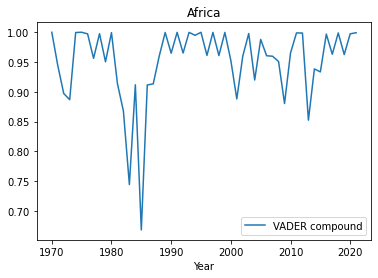

In [14]:
x = df_un_merged2.groupby(["Year", "Regions"]).mean()['VADER compound']
x

Africa = df_un_merged2[df_un_merged2['Regions'].str.contains("Africa")]
Africa2 = Africa.groupby(["Year"]).mean(['VADER compound'])
Africa3 = Africa2.drop(columns=["Session"])

Africa3.plot()
plt.title("Africa")
plt.show()

**Sentiment trends: Europe**

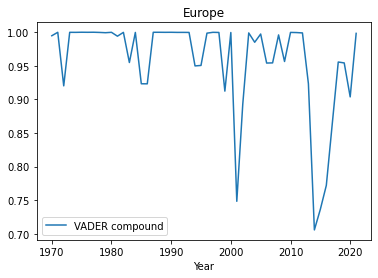

In [15]:
Euro = df_un_merged2[df_un_merged2['Regions'].str.contains("Europe")]
Euro1 = Euro.groupby(["Year"]).mean(['VADER compound'])
Euro2 = Euro1.drop(columns=["Session"])

Euro2.plot()
plt.title("Europe")
plt.show()

**Sentiment trends: Asia**

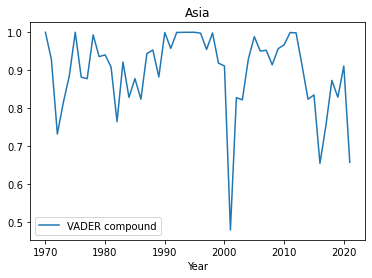

In [16]:
Asia = df_un_merged2[df_un_merged2['Regions'].str.contains("Asia")]
Asia1 = Asia.groupby(["Year"]).mean(['VADER compound'])
Asia2 = Asia1.drop(columns=["Session"])

Asia2.plot()
plt.title("Asia")
plt.show()

**Sentiment trends: Oceania**

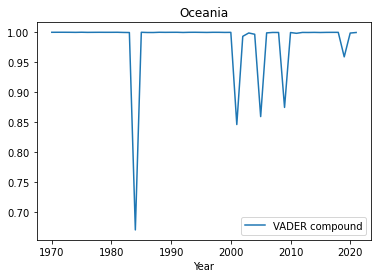

In [17]:
Oceania = df_un_merged2[df_un_merged2['Regions'].str.contains("Oceania")]
Oceania1 = Oceania.groupby(["Year"]).mean(['VADER compound'])
Oceania2 = Oceania1.drop(columns=["Session"])

Oceania2.plot()
plt.title("Oceania")
plt.show()

**Sentiment trends: Latin America**

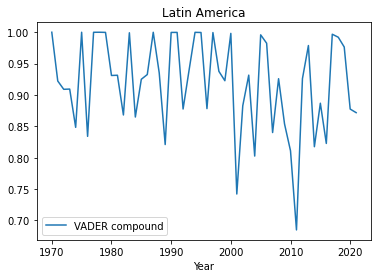

In [18]:
Lat = df_un_merged2[df_un_merged2['Regions'].str.contains("Latin America")]
Lat1 = Lat.groupby(["Year"]).mean(['VADER compound'])
Lat2 = Lat1.drop(columns=["Session"])

Lat2.plot()
plt.title("Latin America")
plt.show()

**Sentiment trends: North America**

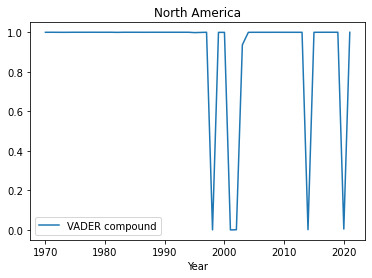

In [19]:
North = df_un_merged2[df_un_merged2['Regions'].str.contains("North America")]
North1 = North.groupby(["Year"]).mean(['VADER compound'])
North2 = North1.drop(columns=["Session"])

North2.plot()
plt.title("North America")
plt.show()

In [20]:
df_un_merged2.groupby(["Year", "Regions"]).mean()['VADER compound']

Year  Regions      
1970  Africa           0.999832
      Asia             0.999682
      Europe           0.994682
      Latin America    0.999833
      North America    0.999700
                         ...   
2021  Asia             0.657280
      Europe           0.998206
      Latin America    0.871700
      North America    0.999600
      Oceania          0.999500
Name: VADER compound, Length: 312, dtype: float64

### 2) Happiness DataFrame

First, we create scatterplotss of all variables against each other.

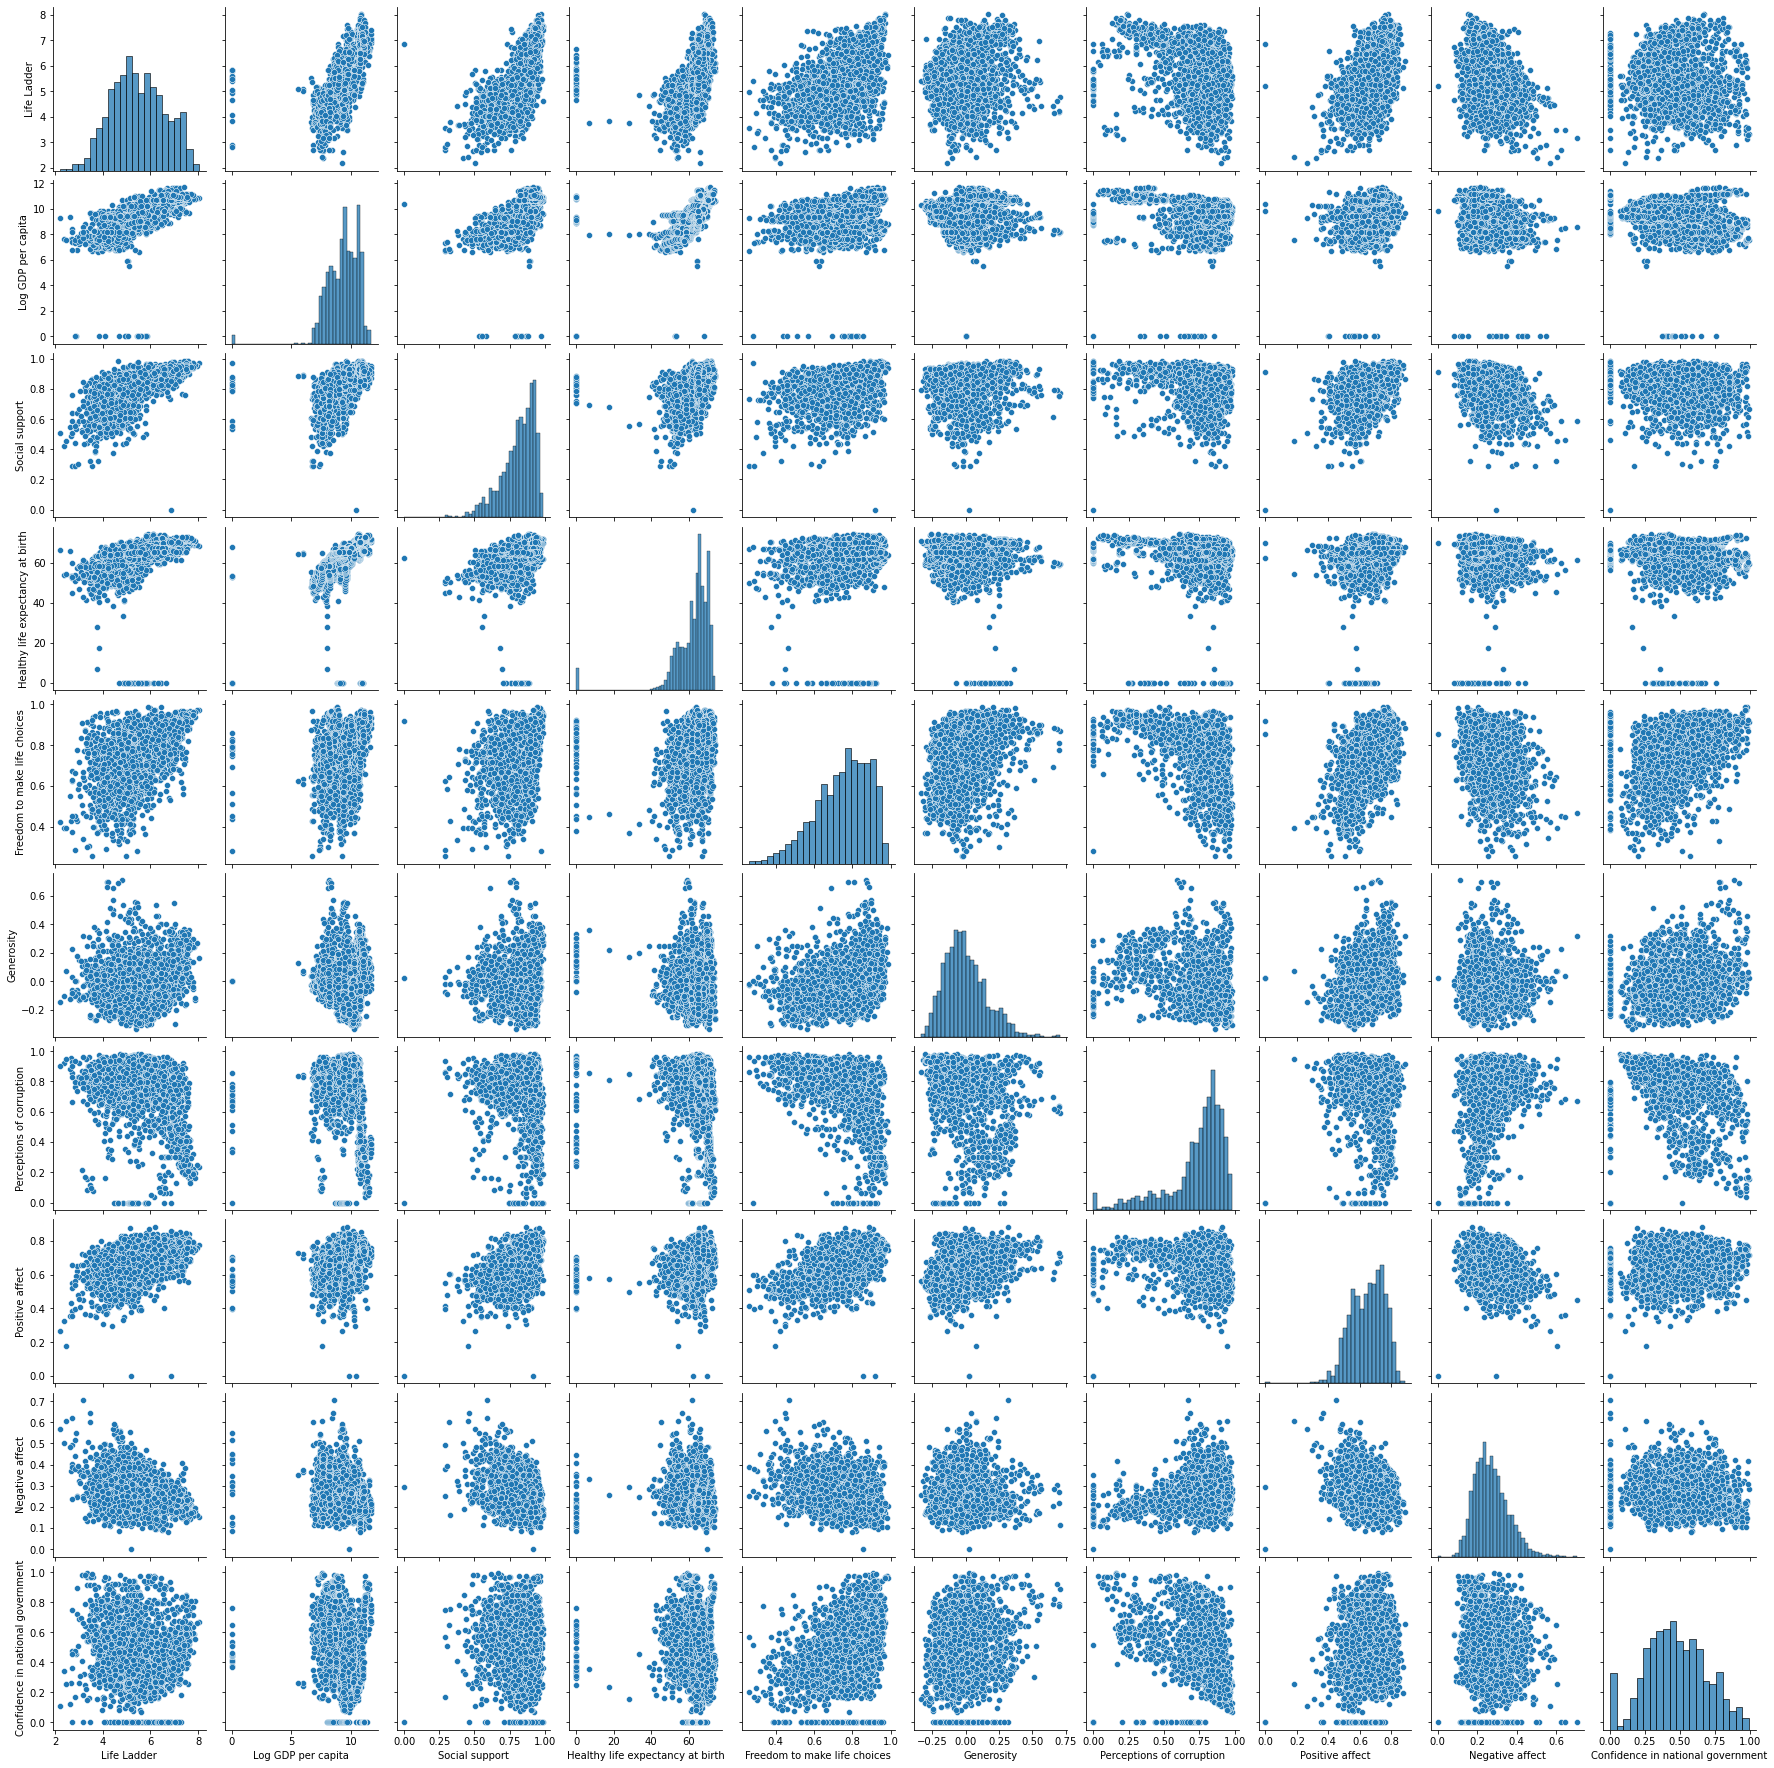

In [21]:
sns.pairplot(happinessdataframe)

For clarity, we also create individual scatterplots of the variable of interest (*Perceptions of corruptions*) against all other variables in the Happiness dataset.

**Scatterplot of "Perceptions of corruption" against "Life Ladder"**

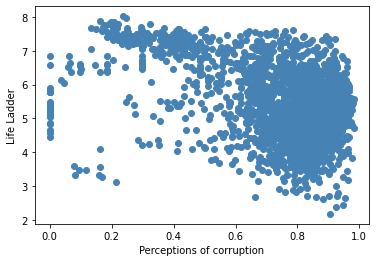

In [22]:
X = happinessdataframe["Perceptions of corruption"].values
Y = happinessdataframe["Life Ladder"].values 

fig, ax = plt.subplots()
ax.scatter(X, Y, c='steelblue')
ax.set_xlabel("Perceptions of corruption")
ax.set_ylabel("Life Ladder")
plt.show()

**Scatterplot of "Perceptions of corruption" against "Log GDP per capita"**

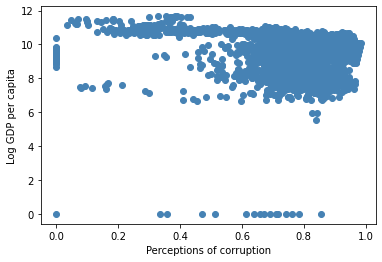

In [23]:
X = happinessdataframe["Perceptions of corruption"].values
Y = happinessdataframe["Log GDP per capita"].values 

fig, ax = plt.subplots()
ax.scatter(X, Y, c='steelblue')
ax.set_xlabel("Perceptions of corruption")
ax.set_ylabel("Log GDP per capita")
plt.show()

**Scatterplot of "Perceptions of corruption" against "Social support"**

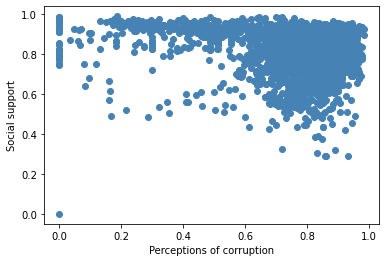

In [24]:
X = happinessdataframe["Perceptions of corruption"].values
Y = happinessdataframe["Social support"].values 

fig, ax = plt.subplots()
ax.scatter(X, Y, c='steelblue')
ax.set_xlabel("Perceptions of corruption")
ax.set_ylabel("Social support")
plt.show()

**Scatterplot of "Perceptions of corruption" against "Healthy life expectancy at birth"**

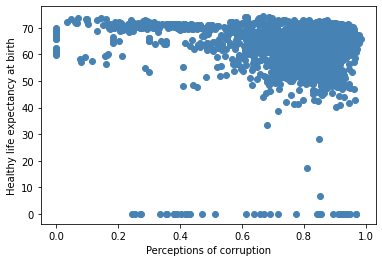

In [25]:
X = happinessdataframe["Perceptions of corruption"].values
Y = happinessdataframe["Healthy life expectancy at birth"].values 

fig, ax = plt.subplots()
ax.scatter(X, Y, c='steelblue')
ax.set_xlabel("Perceptions of corruption")
ax.set_ylabel("Healthy life expectancy at birth")
plt.show()

**Scatterplot of "Perceptions of corruption" against "Freedom to make life choices"**

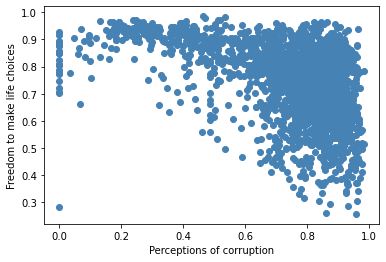

In [26]:
X = happinessdataframe["Perceptions of corruption"].values
Y = happinessdataframe["Freedom to make life choices"].values 

fig, ax = plt.subplots()
ax.scatter(X, Y, c='steelblue')
ax.set_xlabel("Perceptions of corruption")
ax.set_ylabel("Freedom to make life choices")
plt.show()

**Scatterplot of "Perceptions of corruption" against "Generosity"**

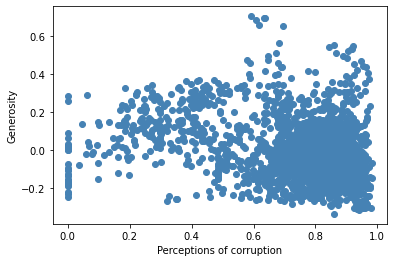

In [27]:
X = happinessdataframe["Perceptions of corruption"].values
Y = happinessdataframe["Generosity"].values 

fig, ax = plt.subplots()
ax.scatter(X, Y, c='steelblue')
ax.set_xlabel("Perceptions of corruption")
ax.set_ylabel("Generosity")
plt.show()

**Scatterplot of "Perceptions of corruption" against "Positive affect"**

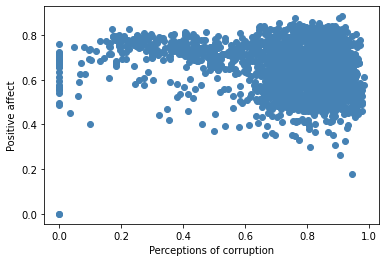

In [28]:
X = happinessdataframe["Perceptions of corruption"].values
Y = happinessdataframe["Positive affect"].values 

fig, ax = plt.subplots()
ax.scatter(X, Y, c='steelblue')
ax.set_xlabel("Perceptions of corruption")
ax.set_ylabel("Positive affect")
plt.show()

**Scatterplot of "Perceptions of corruption" against "Negative affect"**

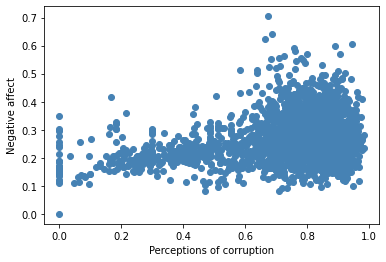

In [29]:
X = happinessdataframe["Perceptions of corruption"].values
Y = happinessdataframe["Negative affect"].values 

fig, ax = plt.subplots()
ax.scatter(X, Y, c='steelblue')
ax.set_xlabel("Perceptions of corruption")
ax.set_ylabel("Negative affect")
plt.show()

**Scatterplot of "Perceptions of corruption" against "Confidence in national government"**

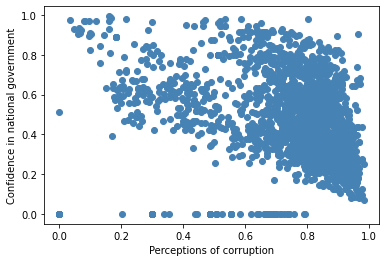

In [30]:
X = happinessdataframe["Perceptions of corruption"].values
Y = happinessdataframe["Confidence in national government"].values 

fig, ax = plt.subplots()
ax.scatter(X, Y, c='steelblue')
ax.set_xlabel("Perceptions of corruption")
ax.set_ylabel("Confidence in national government")
plt.show()

Next, we create correlation heatmaps between all variables, as well as all variables with the variable of interest isolated.

<AxesSubplot:>

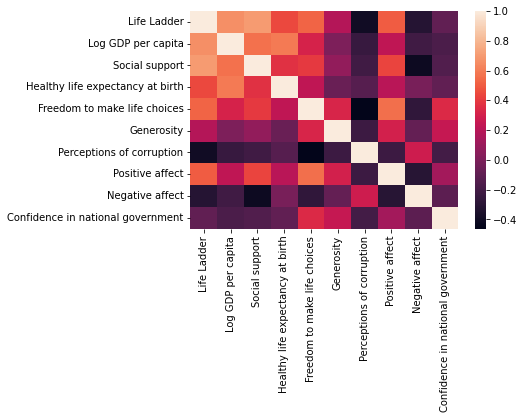

In [31]:
sns.heatmap(happinessdataframe.corr())

Text(0.5, 1.0, 'Features Correlating with Perceptions of Corruption')

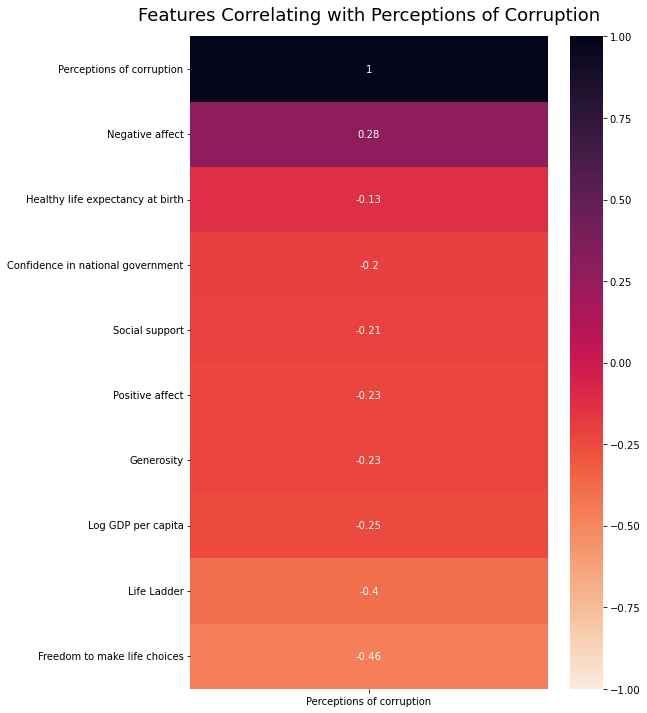

In [32]:
plt.figure(figsize=(8, 12))

heatmap = sns.heatmap(happinessdataframe.corr()[['Perceptions of corruption']].sort_values(by='Perceptions of corruption', ascending=False), vmin=-1, vmax=1, annot=True, cmap='rocket_r')

heatmap.set_title('Features Correlating with Perceptions of Corruption', fontdict={'fontsize':18}, pad=16)

## Predictive Analysis

### Merging the two datasets 

In [33]:
new = df_un_merged2[['Regions', 'VADER compound', 'VADER sentiment', 'Country or Area', 'Year']].copy()
new

new.rename(columns={'Country or Area': 'Country name', 'Year': 'year'}, inplace=True)
new

un_new = new.set_index(['Country name','year'])
un_new

Regions  VADER compound VADER sentiment
Country name year                                        
Austria      1970  Europe          1.0000        positive
             1971  Europe          0.9999        positive
             1972  Europe          0.9999        positive
             1973  Europe          0.9997        positive
             1974  Europe          0.9992        positive
...                   ...             ...             ...
South Sudan  2016  Africa          0.9998        positive
             2017  Africa          0.9999        positive
             2018  Africa          0.9998        positive
             2019  Africa          0.9999        positive
             2021  Africa          0.9999        positive

[8499 rows x 3 columns]

In [34]:
merged = pd.merge(left=happinessdataframe, left_index=True,
                  right=un_new, right_index=True,
                  how='inner')
merged

Life Ladder  Log GDP per capita  Social support  \
Country name year                                                    
Afghanistan  2008     3.723590            7.302574        0.450662   
             2009     4.401778            7.472446        0.552308   
             2010     4.758381            7.579183        0.539075   
             2011     3.831719            7.552006        0.521104   
             2012     3.782938            7.637953        0.520637   
...                        ...                 ...             ...   
Zimbabwe     2017     3.638300            8.241609        0.754147   
             2018     3.616480            8.274620        0.775388   
             2019     2.693523            8.196998        0.759162   
             2020     3.159802            8.117733        0.717243   
             2021     3.154578            8.153248        0.685151   

                   Healthy life expectancy at birth  \
Country name year                                     
Afghanistan  2008                         50.500000   
             2009                         50.799999   
             2010                         51.099998   
             2011                         51.400002   
             2012                         51.700001   
...                                             ...   
Zimbabwe     2017                         52.150002   
             2018                         52.625000   
             2019                         53.099998   
             2020                         53.575001   
             2021                         54.049999   

                   Freedom to make life choices  Generosity  \
Country name year                                             
Afghanistan  2008                      0.718114    0.173169   
             2009                      0.678896    0.195469   
             2010                      0.600127    0.125859   
             2011                      0.495901    0.167723   
             2012                      0.530935    0.241247   
...                                         ...         ...   
Zimbabwe     2017                      0.752826   -0.113937   
             2018                      0.762675   -0.084747   
             2019                      0.631908   -0.081540   
             2020                      0.643303   -0.029376   
             2021                      0.667636   -0.109439   

                   Perceptions of corruption  Positive affect  \
Country name year                                               
Afghanistan  2008                   0.881686         0.414297   
             2009                   0.850035         0.481421   
             2010                   0.706766         0.516907   
             2011                   0.731109         0.479835   
             2012                   0.775620         0.613513   
...                                      ...              ...   
Zimbabwe     2017                   0.751208         0.733641   
             2018                   0.844209         0.657524   
             2019                   0.830652         0.658434   
             2020                   0.788523         0.660658   
             2021                   0.756945         0.609917   

                   Negative affect  Confidence in national government Regions  \
Country name year                                                               
Afghanistan  2008         0.258195                           0.612072    Asia   
             2009         0.237092                           0.611545    Asia   
             2010         0.275324                           0.299357    Asia   
             2011         0.267175                           0.307386    Asia   
             2012         0.267919                           0.435440    Asia   
...                            ...                                ...     ...   
Zimbabwe     2017         0.224051                           0.682647  Africa 

### Stepwise regression

First, we perform a step-down regression to see whether all variables from the Happiness dataset have explanatory power in predicting the variable of interest, *Perceptions of corruption*. 

In [53]:
col_list = list(merged.columns)
col_list.remove("VADER sentiment")
col_list.remove("VADER compound")
col_list.remove("Perceptions of corruption")
col_list.remove("Regions")

features = col_list[:]

x_columns = features
y = merged["Perceptions of corruption"]

In [54]:
def get_stats():
    x_d = merged[features]
    x_column = sm.add_constant(x_d)
    results = sm.OLS(y, x_column).fit()
    print(results.summary())
get_stats()

                                OLS Regression Results                               
Dep. Variable:     Perceptions of corruption   R-squared:                       0.333
Model:                                   OLS   Adj. R-squared:                  0.330
Method:                        Least Squares   F-statistic:                     96.19
Date:                       Sat, 01 Oct 2022   Prob (F-statistic):          1.28e-145
Time:                               19:17:53   Log-Likelihood:                 554.55
No. Observations:                       1742   AIC:                            -1089.
Df Residuals:                           1732   BIC:                            -1034.
Df Model:                                  9                                         
Covariance Type:                   nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

The variable *Log GDP per capita* has the highest value. We exclude it from the model and call the function *get_stats()* again. 

In [55]:
x_columns.remove("Log GDP per capita")
get_stats()

                                OLS Regression Results                               
Dep. Variable:     Perceptions of corruption   R-squared:                       0.333
Model:                                   OLS   Adj. R-squared:                  0.330
Method:                        Least Squares   F-statistic:                     108.2
Date:                       Sat, 01 Oct 2022   Prob (F-statistic):          1.35e-146
Time:                               19:17:54   Log-Likelihood:                 554.42
No. Observations:                       1742   AIC:                            -1091.
Df Residuals:                           1733   BIC:                            -1042.
Df Model:                                  8                                         
Covariance Type:                   nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

The variable *Healthy life expectancy at birth* has the highest value. We exclude it from the model and call the function *get_stats()* again. 

In [56]:
x_columns.remove("Healthy life expectancy at birth")
get_stats()

                                OLS Regression Results                               
Dep. Variable:     Perceptions of corruption   R-squared:                       0.332
Model:                                   OLS   Adj. R-squared:                  0.329
Method:                        Least Squares   F-statistic:                     123.1
Date:                       Sat, 01 Oct 2022   Prob (F-statistic):          5.62e-147
Time:                               19:17:55   Log-Likelihood:                 552.84
No. Observations:                       1742   AIC:                            -1090.
Df Residuals:                           1734   BIC:                            -1046.
Df Model:                                  7                                         
Covariance Type:                   nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

All variables have signficiant explanatory power. Therefore, we terminate the step-down regression process and move on to training the model. 

In [57]:
# Create a train and validation set

X = merged[["Life Ladder", "Social support", "Freedom to make life choices", "Generosity", "Positive affect", "Negative affect", "Confidence in national government"]].values
y = merged["Perceptions of corruption"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Create grid of parameters to test through cross-validation
param_grid = {'polynomialfeatures__degree': np.arange(2),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

model = make_pipeline(PolynomialFeatures(), LinearRegression())
grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(X_train, y_train);

# Let us know check the results with the best estimator after Grid Search
print("Best hyperparameters found:")
print(grid.best_params_)
y_pred = grid.best_estimator_.predict(X_test)
print("")

# Compute test error and variance score
print("Model accuracy:")
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print("")

Best hyperparameters found:
{'linearregression__fit_intercept': True, 'linearregression__normalize': True, 'polynomialfeatures__degree': 1}

Model accuracy:
Mean squared error: 0.03
Variance score: 0.30



In [58]:
# Create a train and validation set

X = merged[["Life Ladder", "Social support", "Freedom to make life choices", "Generosity", "Positive affect", "Negative affect", "Confidence in national government", "VADER compound"]].values
y = merged["Perceptions of corruption"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Create grid of parameters to test through cross-validation
param_grid = {'polynomialfeatures__degree': np.arange(2),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

model = make_pipeline(PolynomialFeatures(), LinearRegression())
grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(X_train, y_train);

# Let us know check the results with the best estimator after Grid Search
print("Best hyperparameters found:")
print(grid.best_params_)
y_pred = grid.best_estimator_.predict(X_test)
print("")

# Compute test error and variance score
print("Model accuracy:")
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print("")

Best hyperparameters found:
{'linearregression__fit_intercept': True, 'linearregression__normalize': False, 'polynomialfeatures__degree': 1}

Model accuracy:
Mean squared error: 0.03
Variance score: 0.31



**CONCLUSION**: Including the vader compound score increase the performance of the model by 1% according to the R2 score. (MSE stays the same). 

In [59]:
col_list = list(merged.columns)
col_list.remove("VADER sentiment")
col_list.remove("Perceptions of corruption")
col_list.remove("Regions")

features = col_list[:]

x_columns = features

get_stats()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     86.64
Date:                Sat, 01 Oct 2022   Prob (F-statistic):          8.53e-145
Time:                        19:18:37   Log-Likelihood:                 554.97
No. Observations:                1742   AIC:                            -1088.
Df Residuals:                    1731   BIC:                            -1028.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

While the R2 of the model improves (by 1%) the *VADER compound* variable is not significant.